In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import erf
import emcee
from scipy.optimize import root_scalar
import agama
import corner
import astropy.coordinates as coord
import astropy.units as u
import multiprocessing

In [3]:
1.9*7e4

133000.0

In [4]:
agama.setUnits(length=1, mass=1e10, velocity=1)
# 常数和参数（单位：kpc, Gyr, 10^10 Msun）
G = 43018  # 单位转换后：kpc³/(10¹⁰ Msun·Gyr²)
M_bulge = 1.0    # 10¹⁰ Msun (原1e10 Msun)
M_disk = 5.     # 10¹⁰ Msun (原5e10 Msun)
a_disk = 3.     # kpc
a_bulge = 0.5 
v_disper = 80
M_LMC = 20
a_halo = 30
M_halo = 5.56*(1+8.2/a_halo)**2/(8.2/a_halo)**2
print(M_halo)

120.66291493158835


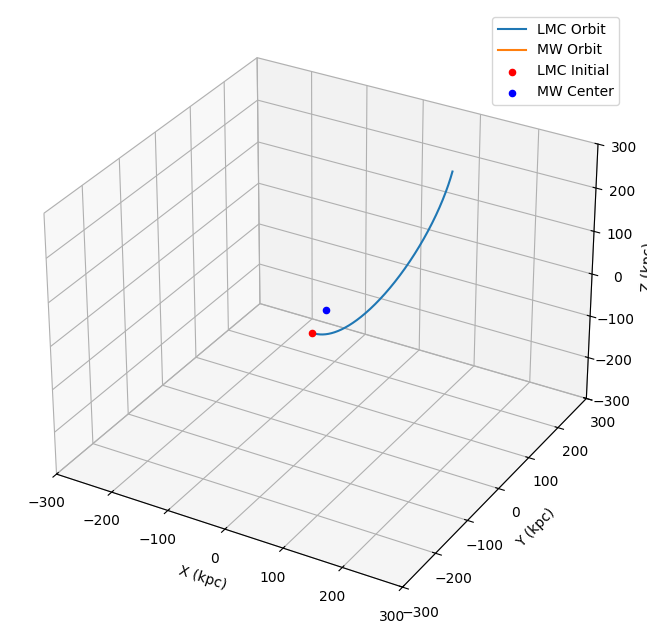

In [ ]:

rlmc_200 = (43018*M_LMC)**(1/3) 
rlmc_scal = 8.5*(M_LMC/10)**0.6
c_LMC = rlmc_200/rlmc_scal
a_LMC = rlmc_scal*np.sqrt(2*(np.log(1+c_LMC)-c_LMC/(1+c_LMC)))
#para_halo = agama.Density(type='Dehnen', mass=M_halo, scaleRadius=a_halo, gamma = 1, axisRatioZ=q_MW)
para_bulge = agama.Density(type='Dehnen', mass=M_bulge, scaleRadius=a_bulge, gamma = 1)
para_disk = agama.Density(type='Disk', mass=M_disk, scaleRadius=a_disk, scaleHeight=b_disk,sersicIndex=1)
# potential
MWpot = agama.Potential(type='Multipole',density=para_bulge+para_halo,
                                    lmax=12, gridSizeR=1000, rmin=1e-1, rmax=300)
#pot_cyl = agama.Potential(type='CylSpline',density=para_disk,
#                                   gridSizeR=50, gridSizez=30, Rmin=0.1, Rmax=50, zmin=0.001, zmax=20, mmax=8)


LMCpot = agama.Potential(type='Dehnen', mass=M_LMC, scaleRadius=a_LMC, gamma = 1)

def rotation_matrix_x(theta):
    """
    绕 x 轴旋转的旋转矩阵 (角度 theta)
    参数:
        theta: 绕 x 轴旋转的角度 (弧度)
    返回:
        3x3 旋转矩阵
    """
    return np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    
def rotation_matrix_y(phi):
    """
    绕 y 轴旋转的旋转矩阵 (角度 phi)
    参数:
        phi: 绕 y 轴旋转的角度 (弧度)
    返回:
        3x3 旋转矩阵
    """
    return np.array([
        [np.cos(phi), 0, np.sin(phi)],
        [0, 1, 0],
        [-np.sin(phi), 0, np.cos(phi)]
    ])

def rotation_matrix_z(phi):
    """
    绕 z 轴旋转的旋转矩阵 (角度 phi)
    参数:
        phi: 绕 z 轴旋转的角度 (弧度)
    返回:
        3x3 旋转矩阵
    """
    return np.array([
        [np.cos(phi), -np.sin(phi), 0],
        [np.sin(phi), np.cos(phi), 0],
        [0, 0, 1]
    ])

#坐标系转换
def Galactic_to_icrs(pos,vel):
    gc = coord.SkyCoord(x= pos[0]* u.kpc, y=pos[1]* u.kpc,
            z= pos[2]* u.kpc,
            v_x= vel[0]* u.km / u.s,
            v_y= vel[1]* u.km / u.s,
            v_z= vel[2]* u.km / u.s, frame='galactocentric',
            representation_type='cartesian', differential_type='cartesian',
            galcen_distance=8.122* u.kpc, z_sun=20.8 * u.pc,
            galcen_v_sun=coord.CartesianDifferential(
                 [12.9, 245.6, 7.8] * u.km / u.s))
    c = gc.transform_to(coord.ICRS)
    ra = np.array(c.ra)
    dec = np.array(c.dec)
    distance = np.array(c.distance)
    pmra = np.array(c.pm_ra_cosdec)
    pmdec = np.array(c.pm_dec)
    vr = np.array(c.radial_velocity)
    return ra, dec, distance, pmra, pmdec, vr
# 动力摩擦（简化三维模型）
def a_df(r, v):  
    
    v_norm = np.linalg.norm(v)  # 避免除零
    r_norm = np.linalg.norm(r)  # 避免除零

    ln_Lambda = 1/2*np.log(1+(r_norm/a_LMC/0.75)**2) # 度量参数
    
    
    # 根据 Hernquist 分布计算 rho_halo
    rho_halo = MWpot.density(r)  # 计算银河系的密度
    # 计算 X 和误差函数项
    X_c = v_norm / (2**0.5 *120)  # 假设速度分散为 200 km/s
    erf_term = erf(X_c) - 2 * X_c / np.sqrt(np.pi) * np.exp(-X_c**2)

    # 动力摩擦力
    a  = 4 * np.pi * G**2 * M_LMC * rho_halo * ln_Lambda * erf_term * v / v_norm**3

    
    return a

# 微分方程组
def equations(t, y):
    # y = [x_LMC, y_LMC, z_LMC, vx_LMC, vy_LMC, vz_LMC, x_MW, y_MW, z_MW, vx_MW, vy_MW, vz_MW]
    r_LMC = y[0:3]
    v_LMC = y[3:6]
    r_MW = y[6:9]
    v_MW = y[9:12]
    
    r_relative = r_LMC - r_MW
    
    # LMC的加速度
    acc_LMC = MWpot.force(r_relative) + a_df(r_relative,v_LMC - v_MW) +LMCpot.force(r_relative)
    
    # 银河系的加速度
    acc_MW =  np.array([0,0,0])#LMCpot.force(-r_relative)#
    
    return np.concatenate((v_LMC, acc_LMC, v_MW, acc_MW))


# 初始条件（kpc, km/s需转换）
y0 = np.zeros(12)
y0[0:3] = [-0.6143609652013762,-41.02036741646231, -26.832974651917674]#[500,0,0] # LMC初始位置
y0[3:6] =  [69.81047009397867, 221.9356211949808, -214.01029566668603]#[0,40,0]#     # LMC初始速度
y0[6:9] = [0, 0, 0]     # 银河系初始位置在原点
y0[9:12] = [0, 0, 0]    # 银河系初始静止

# 时间范围（Gyr）
t_span = (0, 3)  # 积分10 Gyr

# 求解ODE
sol = solve_ivp(equations, t_span, y0, method='RK45', rtol=1e-7,t_eval=np.linspace(t_span[0], t_span[1], 1000))

# 提取结果
t = sol.t
x_LMC, y_LMC, z_LMC = sol.y[0], sol.y[1], sol.y[2]
vx_LMC, vy_LMC, vz_LMC = sol.y[3], sol.y[4], sol.y[5]
x_MW, y_MW, z_MW = sol.y[6], sol.y[7], sol.y[8]


# 三维轨迹可视化
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_LMC, y_LMC, z_LMC, label='LMC Orbit')
ax.plot(x_MW, y_MW, z_MW, label='MW Orbit')
ax.scatter(x_LMC[0], y_LMC[0], z_LMC[0], c='r', marker='o', label='LMC Initial')
ax.scatter(x_MW[0], y_MW[0], z_MW[0], c='b', marker='o', label='MW Center')
ax.set_xlabel('X (kpc)')
ax.set_ylabel('Y (kpc)')
ax.set_zlabel('Z (kpc)')
ax.set_xlim(-300, 300)
ax.set_ylim(-300, 300)
ax.set_zlim(-300, 300)
plt.legend()
plt.show()

t=3 Gyr时的LMC位置: (27.14, 350.69, 111.95) kpc
t=3 Gyr时的LMC速度: (-5.35, 42.29, 60.07) km/s
t=3 Gyr时的银河系位置: (0.00, 0.00, 0.00) kpc


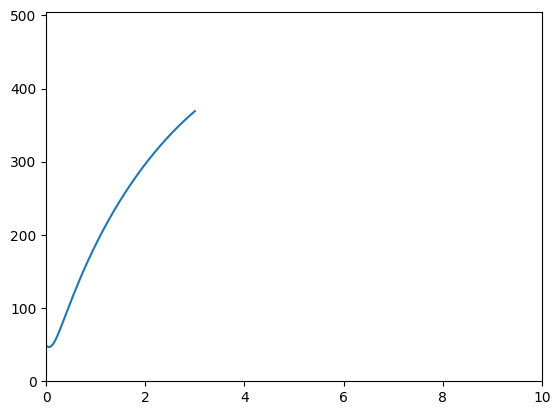

In [13]:
rlmc_mw = np.sqrt((x_LMC-x_MW)**2 + (y_LMC-y_MW )**2 + (z_LMC-z_MW)**2)
from matplotlib_scalebar.scalebar import ScaleBar
fig, ax = plt.subplots()


ax.plot(t, rlmc_mw, label='LMC-MW Distance')
ax.set_xlim(0, 10)
ax.set_ylim(0, 505)



#t=3时候的速度位置
t_index = np.argmin(np.abs(t - 3))
x_LMC_3 = x_LMC[t_index]
y_LMC_3 = y_LMC[t_index]
z_LMC_3 = z_LMC[t_index]
vx_LMC_3 = vx_LMC[t_index]
vy_LMC_3 = vy_LMC[t_index]
vz_LMC_3 = vz_LMC[t_index]
x_MW_3 = x_MW[t_index]
y_MW_3 = y_MW[t_index]
z_MW_3 = z_MW[t_index]
print(f"t=3 Gyr时的LMC位置: ({x_LMC_3:.2f}, {y_LMC_3:.2f}, {z_LMC_3:.2f}) kpc")
print(f"t=3 Gyr时的LMC速度: ({vx_LMC_3:.2f}, {vy_LMC_3:.2f}, {vz_LMC_3:.2f}) km/s")
print(f"t=3 Gyr时的银河系位置: ({x_MW_3:.2f}, {y_MW_3:.2f}, {z_MW_3:.2f}) kpc")

In [8]:
print(x_LMC[-1],y_LMC[-1],z_LMC[-1])

0.04171280578188162 -0.037810309977445264 0.00501275513720068


In [43]:
t=3 Gyr时的LMC位置: (42.16, -30.57, -250.20) kpc
t=3 Gyr时的LMC速度: (-9.30, -60.75, 5.60) km/s

t=3 Gyr时的LMC位置: (10.41, 238.64, 119.75) kpc
t=3 Gyr时的LMC速度: (-12.72, -16.76, 56.32) km/s


SyntaxError: invalid syntax (1818273762.py, line 1)